# CH.09

## Optimizer로 수행하는 매개변수 갱신

### 매개변수 갱신 사용 방법
- 경사하강법 사용
- 다양한 최적화 기법
### 이번 단계 수행 작업
- 매개변수 갱신 작업 모듈화
- 쉽게 다른 모듈로 대체할 수 있는 구조 만들기


## Optimizer 클래스
- 매개변수 갱신을 위한 기반 클래스
- target, hooks 인스턴스 변수
- setup 메서드(target = layer or model)
- update 메서드(모든 매개변수 갱신)
- update_one(구체적인 매개변수 갱신)
- 전처리 add_hook 메서드 

In [1]:
import math
from dezero import cuda, Parameter, Layer, Model

class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []

    # 매개변수를 갖는 타겟(레이어나 모델)을 설정한다.
    def setup(self, target: Layer | Model):
        self.target = target
        return self

    # 모든 매개변수를 갱신한다. but grad is None인 매개변수는 갱신하지 않는다.
    def update(self):
        params = [p for p in self.target.params() if p.grad is not None]

        # 전처리 (Weight decay(Regularization), Gradient clipping 등)
        # example/mnist.py 참조
        for f in self.hooks:
            f(params)

        # 매개변수 갱신
        for param in params:
            self.update_one(param)

    # 하위 클래스에서 메서드 구현
    def update_one(self, param):
        raise NotImplementedError()

    def add_hook(self, f):
        self.hooks.append(f)

## SGD 클래스 
- 경사하강법으로 매개변수를 갱신하는 클래스
- Optimizer 클래스를 상속
- update_one(매개변수 갱신 코드 구현)

In [2]:
class SGD(Optimizer):  # (확률적)경사하강법
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr

    def update_one(self, param):
        param.data -= self.lr * param.grad.data

In [3]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F


np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10


class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y


model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649356)
variable(0.0788816650635515)
variable(0.07655073683421637)
variable(0.07637803086238226)
variable(0.07618764131185567)


## 기울기를 이용한 최적화 기법
1. Momentum
2. AdaGrad
3. AdaDelta
4. Adam
- Optimizer 클래스를 상속하여 다양한 최적화 기법을 구현

## Momentum 기법
$ v \gets av - \eta\frac{\partial L}{\partial W} $     
$W \gets W + v$

- $W$ = 가중치 매개변수   
- $\frac{\partial L}{\partial W}$ = 기울기    
- $\eta$ = 학습률
- $v$ = 속도
- $av$ = 물체가 아무런 힘을 받지 않을 때 서서히 감속시키는 역할

In [4]:
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        #속도 데이터, 딕셔너리 타입의 인스턴스 변수 
        self.vs = {}

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            xp = cuda.get_array_module(param.data)
            self.vs[v_key] = xp.zeros_like(param.data)
        # 속도 먼저 계산
        v = self.vs[v_key]
        # 모멘텀만큼 이전 속도를 반영하고, 학습률을 반영한 param의 grad를 빼준다.
        # (v <- v * momentum - lr * gW)
        v *= self.momentum
        v -= self.lr * param.grad.data
        # param에 속도를 더해준다. (W <- W + v)
        param.data += v

## 다중 클래스(Multi-class Classification) 분류
- 여러 클래스로 분류하는 문제
- 분류 대상이 여러 가지 클래스 중 어디에 속하는지 추정

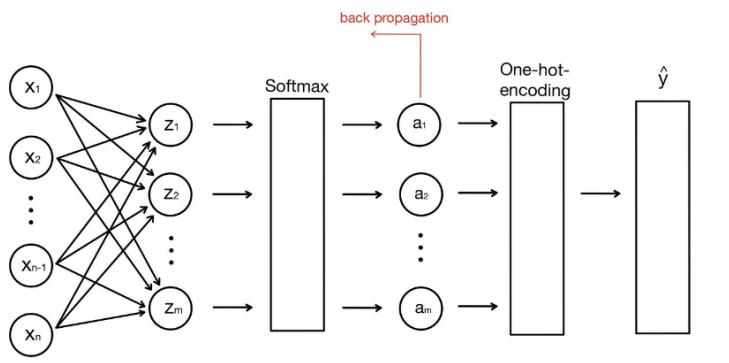

## 소프트 맥스 함수
- 신경망 출력이 단순한 수치인데, 이 수치를 확률로 변환  
$p_k = \frac{exp(y_K)}{\displaystyle\sum_{i=1}^n exp(y_i)} $
- 소프트맥스 함수의 입력 $y_k$가 총 n개라고 가정
- K 번째 출력 $p_k$를 구하는 계산식
- 분자는 입력 𝑦𝑘 의 지수 함수고, 분모는 모든 입력 지수 함수의 총합 ( 0 <= 𝑝𝑖 <= 1)

In [11]:
from dezero import Variable, as_variable
from dezero.models import MLP
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

model = MLP((10,3))
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[-0.51222398 -0.48154886 -0.19620913]])
variable([[0.29387554 0.30302989 0.40309457]])


### 배치 데이터를 처리하는 소프트맥스 함수
- axis = 행축  
- keepdims=True 이므로 각 행에서 나눗셈 

In [12]:
def softmax_simple(x, axis = 1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis = axis, keepdims = True)
    return y / sum_y

## 교차 엔트로피 오차(Cross Entropy Error)
- 다중 클래스 분류에 적합한 손실 함수  
$L = -\displaystyle\sum_{k} t_k\log p_k $
- 정답 데이터의 원소는 정답에 해당하는 클래스면 1로, 그렇지 않으면 0으로 기록
- 이러한 표현 방식을 원핫 벡터 (onehot vector)라 함- 𝑝𝑘 는 신경망에서 소프트맥스 함수를 적용한 후의 출력
- 정답 클래스에 해당하는 번호의 확률 p를 추출함으로써 교차 엔트로피의 오차를 계산  
$L=-\log p[t]$


In [13]:
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    p = softmax(x)
    p = clip(p, 1e-15, 1.0)  
    log_p = log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

In [17]:
x = np.array([[0.2, -0.4],[0.3,0.5],[1.3,-3.2],[2.1,0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy_simple(y, t)
print(loss)

variable(1.005250977723018)


## 다중 클래스 분류 수행
- 소프트맥스 함수, 교차 엔트로피 오차

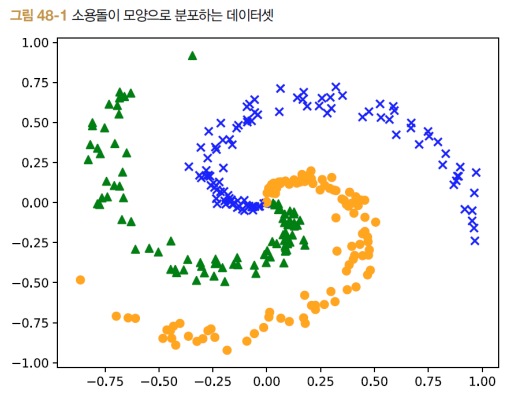

### 스파이럴 데이터셋
- train=True 면 학습용 데이터를 반환, False 면 테스트용 데이터를 반환
- x = 입력 데이터, t = 정답 데이터
- 문제는 3클래스 분류이므로 t이 원소는 0, 1, 2 중 하나가 됨

In [20]:
import dezero.datasets as ds

x, t = ds.get_spiral(train=True)
print(x.shape)
print(t.shape)
print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


In [23]:
import math
import numpy as np
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero.models import MLP

# 하이퍼라마터 설정 - 은닉층 수와 학습률, 배치 크기
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 데이터 읽기 / 모델, 옵티마이저 생성
train_set = dezero.datasets.Spiral(train=True) #훈련 데이터
model = MLP((hidden_size, 3)) #은닉층 10개, 출력 3개 
optimizer = optimizers.SGD(lr).setup(model) #Optimizer = SGD(경사하강법)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니매치 생성
        batch_index = index[i * batch_size : (i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])
        # 기울기 산출 / 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

   
    avg_loss = sum_loss / data_size
    print("epoch %d, loss %.2f" % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

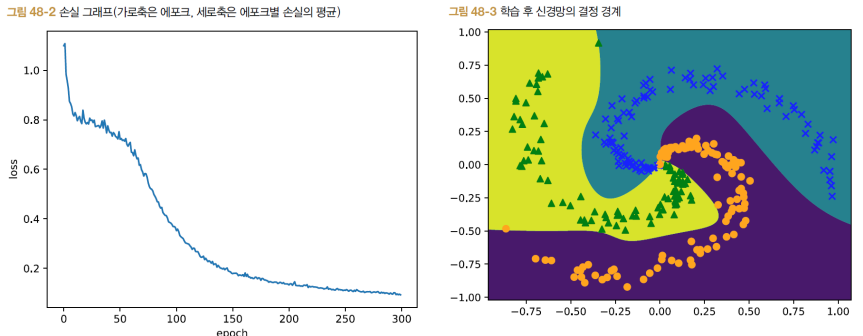

# Attention

## seq2seq의 문제점
- Encoder의 출력은 고정 길이 벡터
- 고정 길이 벡터는 입력 문장의 길이에 관계없이 항상 같은 길이의 벡터로 변환
- 아무리 긴 문장이 입력되더라고 항상 똑같은 길이의 벡터에 밀어 넣음

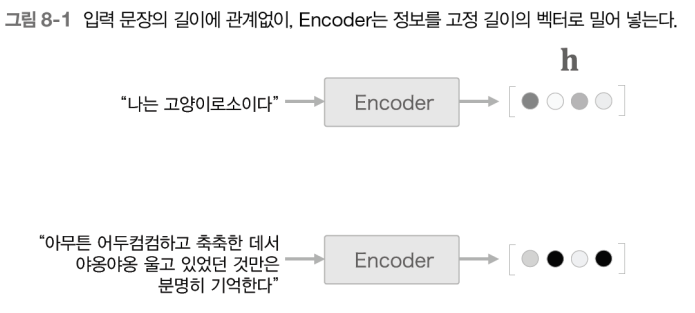

- a = "나는 고양이로소이다" 
- b = "아무튼 어두컴컴하고 축축한 데서 야옹 울고 있었던 것만은 분명히 기억한다"    
- a의 길이 < b의 길이
- a -> encoder(a) -> vector h의 길이 = b -> encoder(b) -> vector h의 길이

## Encodere 개선
- LSTM 계층의 마지막 은닉 상태만을 Decoder에 전달
- Encoder의 출력 길이는 입력 문장에 따라 바꿔주도록 함
- 은닉 상태 벡터를 모두 이용하면 입력된 단어와 같은 수의 벡터를 얻음

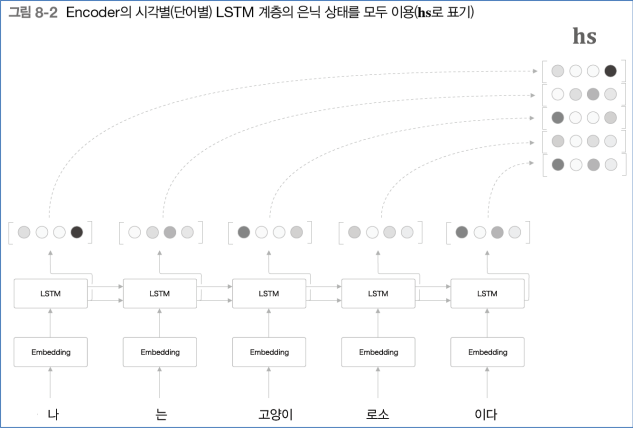

## Encodere 개선
- Encoder 출력하는 hs 행렬은 각 단어에 해당하는 벡터들의 집합임-  Encoder는 입력 문장의 길이에 비례한 정보를 인코딩할 수 있음- ▪ hs 가 Decoder에 전달되어 시계열 변환이 이뤄짐

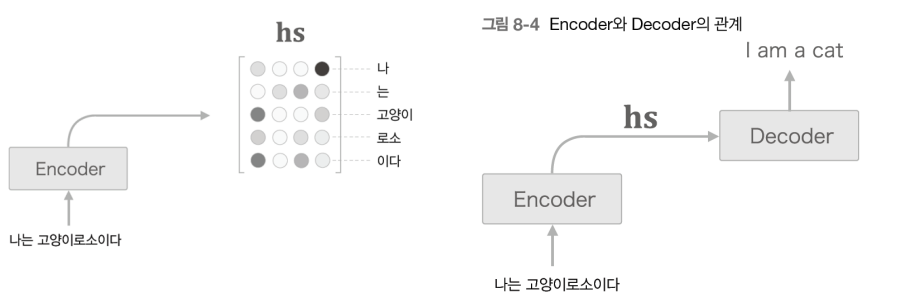

- 단순히 모든 시각의 은닉 상태 벡터를 꺼내는 것만으로, 입력 문장 길이에 비례한 정보를 인코딩 할 수 있게 되었다.

## Decoder의 계층 개선

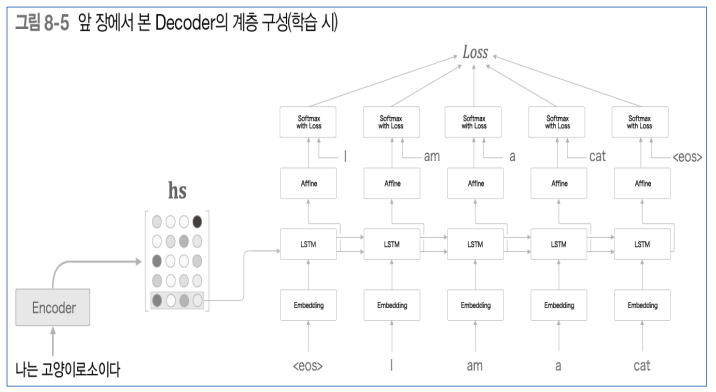

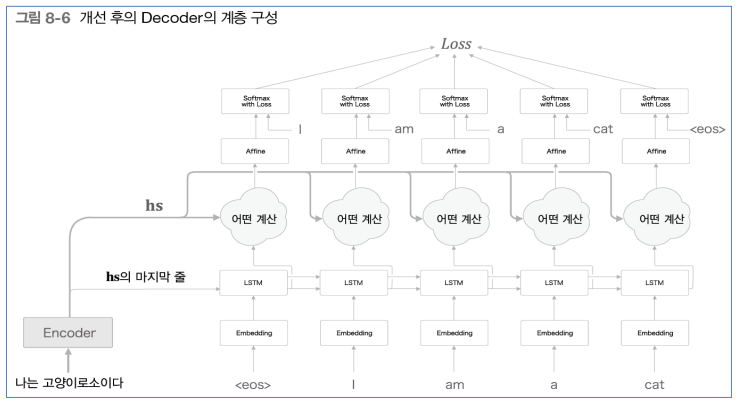

### Attention key point!!
- '도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라 내는 것
- 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것
- 입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가에 대한 대응 관계를 학습할 수 있게 되었다

## 단어에 대한 가중치 구하기
- 단어들의 Alignment(단어의 대응 관계를 나타내는 정보) 추출
    - 각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 hs에서 선택
    - 선택 작업을 어떤 계산으로 수행
    - 선택은 미분가능 하지 않으므로, 모든 것을 선택하여 미분가능하게 만듬
- 단어의 중요도를 나타내는 가중치를 별도로 계산
- 맥락 벡터(c)
    - 가중치 a와 각 단어의 벡터 hs로부터 가중합
    - c = hs $\cdot$ a 만듬

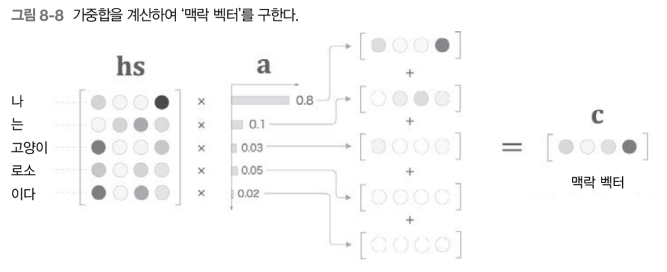

- Weight Sum
- 모든 은닉 상태 벡터(hs)와 가중치를 나타내는 행렬(a)이 연산(행렬곱)하여 그 결과를 합해 맥락 벡터(c)를 얻어낸다

## 가중합 계산 그래프
- T(시계열 길이), H(은닉 상태 벡터 원소수)
- Weight Sum



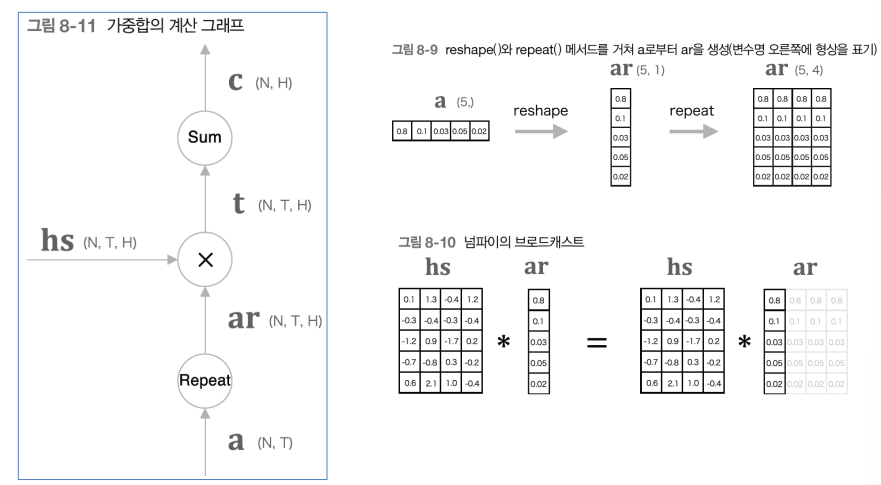

## 가중치 a 구하기
- 가중치 a를 어떻게 구해야 할까?
    - h가 hs의 각 단어 벡터와 얼마나 비슷한가를 수치화 
- 두 벡터의 유사도를 표현하는 내적을 이용
- 소프트맥스 함수를 이용한 정규화

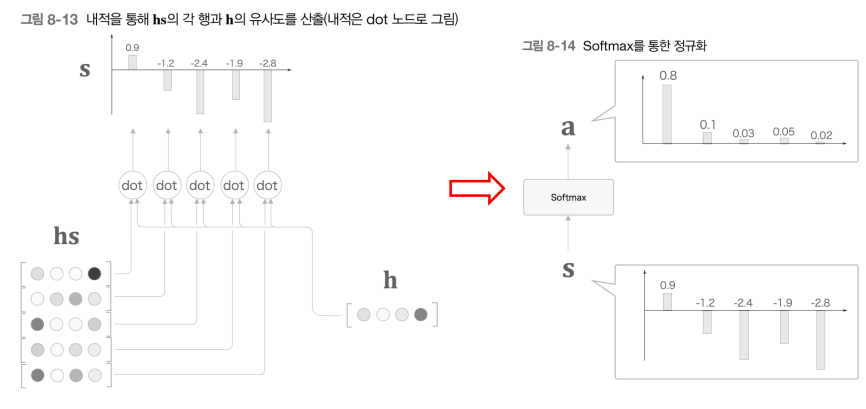

- Attention Weight
- h와 hs의 내적으로 각 단어 벡터의 유사도를 구한 결과가 s이다.
- s는 정규화 하기 이전의 값으로, 점수라고도 한다.
- 이 s를 정규화하기 위해 softmax함수를 적용시켜 나온 결과가 바로 우리가 원하는 가중치 a이다.

## 맥락 벡터를 계산하는 계산 그래프

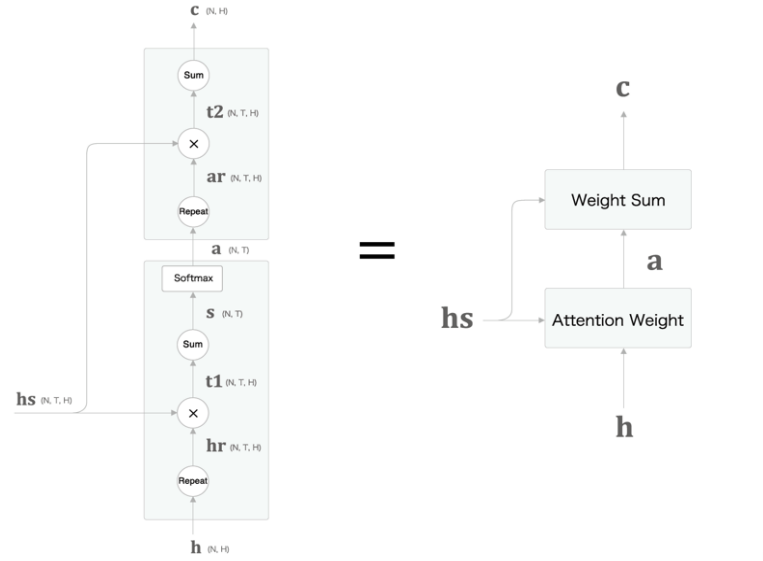

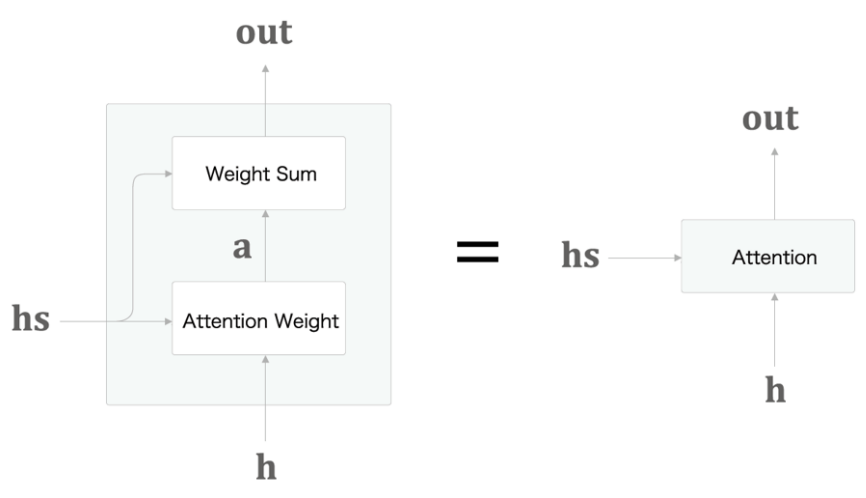

## Attention 계층을 갖춘 Decoder의 계층 구성

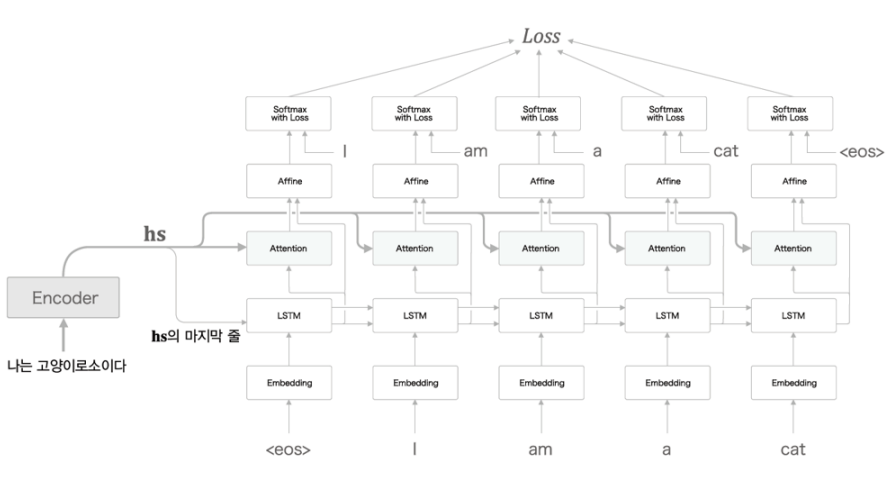